In [1]:
import os
import math
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig, AutoModel
from sklearn.preprocessing import MinMaxScaler
import joblib

import matplotlib.pyplot as plt
from IPython import display
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import CubicSpline

import random

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [3]:
SEED = 42
set_seed(SEED)

## Parameter

In [4]:
class Config:
    # I, V, t column names in your exce
    INPUT_COLS = ["Current(A)", "Voltage(V)", "Time(s)"]
    TARGET_COLS = ["Voltage(V)", "SoC(%)"]

    OCV_FILE_PATH = '../Data/OCV20.xlsx'
    TRAIN_FILE_PATH = '../Data/20_FUDS.xlsx'
    Model_SAVE_DIR = "../Models/"

    SEQ_LEN = 6000
    TRAIN_SPLIT = 0.8

    # head dims
    INPUT_DIM = 3
    HEAD_DIM = 5

    EPOCHS = 3000
    BATCH_SIZE = 100
    LR = 1e-4
    WEIGHT_DECAY = 0.0

    # battery constants
    ETA = 1.08 # coulombic efficiency
    Q_Ah = 1.1 # rated capacity [Ah]

    # loss weights (paper: α=0.2 for voltage; β=1.0 for SOC dynamics)
    ALPHA = 0.2
    BETA = 1.0

cfg = Config()

In [5]:
cfg.SAVED_MODEL_PATH = os.path.join(cfg.Model_SAVE_DIR, 'PIT_20_FUDS_model.pth')
cfg.SAVED_SCALER_PATH = os.path.join(cfg.Model_SAVE_DIR, '20_FUDS_scaler.joblib')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## OCV - SoC

In [18]:
def ocv_lookup_from_excel(ocv_path: str, device: torch.device):

    # 1. Load and clean data using pandas
    df = pd.read_excel(ocv_path)
    soc_col, v_col = 'SoC(CCM)', 'Voltage(V)'
    df = df.dropna(subset=[soc_col, v_col])
    # Ensure that data points are within [0,1] and sorted by SOC
    df = df[(df[soc_col] >= 0.0) & (df[soc_col] <= 1.0)]
    df = df.sort_values(by=soc_col).drop_duplicates(subset=[soc_col])

    soc_np = df[soc_col].to_numpy(np.float64)
    ocv_np = df[v_col].to_numpy(np.float64)

    # 2. Use scipy to compute the coefficients of the cubic spline
    # This is the only place where scipy is used outside of model training
    cs = CubicSpline(soc_np, ocv_np, bc_type='natural')  # Use natural boundary conditions

    # 3. Extract spline parameters (knots and coefficients) and convert them to PyTorch tensors
    # Knots
    knots = torch.tensor(cs.x, dtype=torch.float32, device=device)
    # OCV values at knots
    knots_ocv = torch.tensor(ocv_np, dtype=torch.float32, device=device)
    # Piecewise polynomial coefficients, cs.c has shape (4, n-1), corresponding to coefficients of (x - x_i)^3, ^2, ^1, ^0
    coeffs = torch.tensor(cs.c, dtype=torch.float32, device=device)

    # 4. Return a fully differentiable spline interpolation function implemented in PyTorch
    def ocv_fn(soc_q: torch.Tensor) -> torch.Tensor:
        # Create an empty tensor to store results
        y = torch.zeros_like(soc_q)

        # Identify three regions: below lower bound, within bounds, above upper bound
        is_below = soc_q < knots[0]
        is_above = soc_q > knots[-1]
        is_within = ~(is_below | is_above)

        # --- a) Handle values within bounds ---
        if torch.any(is_within):
            soc_within = soc_q[is_within]

            # Use searchsorted to efficiently locate the interval index of each soc value
            indices = torch.searchsorted(knots, soc_within, right=True) - 1
            # Clamp indices as a safeguard (numerical precision issues)
            indices = torch.clamp(indices, 0, len(knots) - 2)

            # Extract corresponding interval parameters
            x_i = knots[indices]
            a_i, b_i, c_i, d_i = coeffs[0, indices], coeffs[1, indices], coeffs[2, indices], coeffs[3, indices]

            # Compute piecewise cubic polynomial: a(x - x_i)^3 + b(x - x_i)^2 + c(x - x_i) + d
            dx = soc_within - x_i
            y_within = a_i * dx**3 + b_i * dx**2 + c_i * dx + d_i
            y[is_within] = y_within

        # --- b) Handle values below lower bound (linear extrapolation) ---
        if torch.any(is_below):
            # Derivative (slope) of spline at the first knot is c_0
            slope_low = coeffs[2, 0]
            # Use point-slope form y = y1 + m(x - x1)
            y_low = knots_ocv[0] + slope_low * (soc_q[is_below] - knots[0])
            y[is_below] = y_low

        # --- c) Handle values above upper bound (linear extrapolation) ---
        if torch.any(is_above):
            # Compute derivative (slope) of spline at the last knot
            last_idx = len(knots) - 2
            x_i, x_ip1 = knots[last_idx], knots[last_idx + 1]
            a_i, b_i, c_i = coeffs[0, last_idx], coeffs[1, last_idx], coeffs[2, last_idx]
            dx_end = x_ip1 - x_i
            slope_high = 3 * a_i * dx_end**2 + 2 * b_i * dx_end + c_i

            # Use point-slope form y = y1 + m(x - x1)
            y_high = knots_ocv[-1] + slope_high * (soc_q[is_above] - knots[-1])
            y[is_above] = y_high

        return y

    print(f"OCV-SoC curve loaded and wrapped as a differentiable spline function.")
    return ocv_fn


In [19]:
ocv_file_path = cfg.OCV_FILE_PATH
ocv_func = ocv_lookup_from_excel(ocv_file_path, device)

test_soc = torch.tensor([0.5, 0.8]).to(device) #quick test
corresponding_ocv = ocv_func(test_soc)

print(corresponding_ocv)

OCV-SoC curve loaded and wrapped as a differentiable spline function.
tensor([3.2690, 3.3091], device='cuda:0')


## Load Data

In [7]:
class BatteryDataset(Dataset):

    def __init__(self, df: pd.DataFrame, seq_len: int, scaler: MinMaxScaler, config: "Config"):

        self.seq_len = seq_len
        self.scaler = scaler

        # 1. Clean the data
        df_clean = df.dropna(subset=[*config.INPUT_COLS, *config.TARGET_COLS])
        df_clean = df_clean[(df_clean[config.TARGET_COLS[1]] > 0.0) & (df_clean[config.TARGET_COLS[1]] < 1.0)]

        # 2. Extract and convert data to Tensor
        inputs_raw = df_clean.loc[:, config.INPUT_COLS].to_numpy(np.float32)
        model_inputs = df_clean.loc[:, config.INPUT_COLS].to_numpy(np.float32)
        targets = df_clean.loc[:, config.TARGET_COLS].to_numpy(np.float32)
        inputs_scaled = self.scaler.transform(model_inputs)

        self.scaled_data = torch.from_numpy(inputs_scaled)
        self.raw_data = torch.from_numpy(inputs_raw)
        self.target_data = torch.from_numpy(targets)

        n_samples = len(df_clean)

        #in my master thesis experiment, there is only one long sequence
        if n_samples >= self.seq_len:
            # Mode 1: Sequence length is sufficient, perform non-overlapping chunking and discard the remainder
            self.num_sequences = n_samples // self.seq_len
            self._mode = 'chunking'  # Set mode to "chunking"
        else:
            # Mode 2: Sequence length is insufficient, use the entire dataset as a single sequence
            self.num_sequences = 1 if n_samples > 0 else 0 # If empty after cleaning, number of sequences is 0
            self._mode = 'full'      # Set mode to "full"


    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx: int):

        if self._mode == 'chunking':
            start_idx = idx * self.seq_len
            end_idx = start_idx + self.seq_len

            scaled_inputs = self.scaled_data[start_idx:end_idx]
            raw_inputs = self.raw_data[start_idx:end_idx]
            targets = self.target_data[start_idx:end_idx]

        else: # self._mode == 'full'
            scaled_inputs = self.scaled_data
            raw_inputs = self.raw_data
            targets = self.target_data

        return scaled_inputs, raw_inputs, targets

In [8]:
full_df = pd.read_excel(cfg.TRAIN_FILE_PATH)

current_col = cfg.INPUT_COLS[0]  # "Current(A)"
full_df[current_col] = full_df[current_col] * -1 #Discharge is POSITIVE in paper!!! in Dataset usually negative 

full_df = full_df[(full_df[cfg.TARGET_COLS[1]] > 0.0) & (full_df[cfg.TARGET_COLS[1]] < 1.0)]
split_idx = int(len(full_df) * cfg.TRAIN_SPLIT)

train_df = full_df.iloc[:split_idx]
val_df = full_df.iloc[split_idx:]

print(f"Data split: {len(train_df)} for training, {len(val_df)} for validation.")

Data split: 6372 for training, 1594 for validation.


In [9]:
# --- Fitting Scale and save Scaler ---
scaler = MinMaxScaler() 
scaler.fit(train_df[cfg.INPUT_COLS])
#joblib.dump(scaler, cfg.SAVED_SCALER_PATH)
#print(f"Scaler fitted and saved to {cfg.SAVED_SCALER_PATH}")

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [20]:
#sequence_len = len(train_df)

train_dataset = BatteryDataset(train_df, cfg.SEQ_LEN, scaler, cfg)
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)

val_dataset = BatteryDataset(val_df, cfg.SEQ_LEN, scaler, cfg)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False)

ocv_fn = ocv_lookup_from_excel(cfg.OCV_FILE_PATH, device)

C:\Users\Marven\.conda\envs\PINN\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Marven\.conda\envs\PINN\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


OCV-SoC curve loaded and wrapped as a differentiable spline function.


## Model Structure

In [12]:
transformer_config = AutoConfig.from_pretrained(
    "bert-base-uncased", # Use a standard config as a template
    # Key change: Ensure the model can handle our long sequence length
    max_position_embeddings=9000,

    # Increase model complexity for better performance on long sequences
    hidden_size=128,              # Model dimension
    num_hidden_layers=8,          # Number of encoder layers
    num_attention_heads=8,        # Number of attention heads
    intermediate_size=512         # Dimension of the FFN layer
)

# Initialize a model with this new configuration (random weights)
transformer_backbone = AutoModel.from_config(config=transformer_config)

In [13]:
class PITransformer(nn.Module):
    def __init__(self, backbone: nn.Module, in_dim: int, out_dim: int):
        super().__init__()
        self.d_model = backbone.config.hidden_size
        self.in_proj = nn.Linear(in_dim, self.d_model)
        self.backbone = backbone

        self.head = nn.Linear(self.d_model, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.in_proj(x)
        out = self.backbone(inputs_embeds=x).last_hidden_state

        output = self.head(out)

        R0 = torch.nn.functional.softplus(output[:, :, 0])
        R1 = torch.nn.functional.softplus(output[:, :, 1])
        C1 = torch.nn.functional.softplus(output[:, :, 2])
        SOC = 1.5 * torch.sigmoid(output[:, :, 3]) - 0.25
        Uoc = output[:, :, 4]

        y = torch.stack([R0, R1, C1, SOC, Uoc], dim=-1)  # (batch, seq_len, 5)

        return y

## Physics Loss

In [21]:
class PhysLoss(nn.Module):
    def __init__(self, ocv_fn, eta: float, Q_Ah: float, alpha: float, beta: float, burn_in_steps: int = 20):
        super().__init__()
        self.ocv_fn = ocv_fn
        self.eta = eta
        self.Q_As = Q_Ah * 3600.0
        self.alpha = alpha
        self.beta = beta
        self.burn_in = burn_in_steps
        self.mse = nn.MSELoss()

    def forward(self, pred: torch.Tensor, raw_inputs: torch.Tensor, targets: torch.Tensor):
        """pred: (B,L,5) -> [R0,R1,C1,SOC,UOC]
        raw_inputs: (B,L,3) -> [I,V,t] (UNSCALED)
        targets: (B,L,2) -> [V_true, SOC_true]
        """
        pred = pred[:, self.burn_in:, :]
        raw_inputs = raw_inputs[:, self.burn_in:, :]
        targets = targets[:, self.burn_in:, :]

        I = raw_inputs[..., 0]
        V_true = targets[..., 0]
        t = raw_inputs[..., 2]

        R0 = pred[..., 0]
        R1 = pred[..., 1]
        C1 = pred[..., 2]
        SOC = pred[..., 3]
        UOC = pred[..., 4]

        # dt per step; replicate last to keep shape (B,L)
        dt = t[:, 1:] - t[:, :-1]
        dt = torch.cat([dt, dt[:, -1:]], dim=1)

        # RC branch current I1 (per paper Eq.5)
        tau = (R1 * C1).clamp_min(1e-6)

        I1_list = []

        initial_I1 = I[:, 0]
        I1_list.append(initial_I1)

        tau = (R1 * C1).clamp_min(1e-6)
        for k in range(I.shape[1] - 1):
            a = torch.exp(-dt[:, k] / tau[:, k])
            I1_next = a * I1_list[-1] + (1.0 - a) * I[:, k]
            I1_list.append(I1_next)

        I1 = torch.stack(I1_list, dim=1)


        # Predicted terminal voltage UL
        U0 = R0 * I
        V_pred = UOC - R1 * I1 - U0

        # 1) terminal voltage fit loss
        loss_ul = self.mse(V_pred, V_true)

        # 2) OCV-SOC consistency: UOC ≈ h(SOC)
        UOC_ref = self.ocv_fn(SOC)
        loss_uoc = self.mse(UOC, UOC_ref)

        # 3) SOC dynamics
        rhs_instant = -(self.eta / self.Q_As) * I[:, :-1] * dt[:, :-1]
        rhs = torch.cat([torch.zeros_like(rhs_instant[:, 0:1]), torch.cumsum(rhs_instant, dim=1)], dim=1)
        soc_k = SOC[:, 0:1] 
        soc_pred_change = SOC - soc_k
        loss_soc = self.mse(soc_pred_change, rhs)

        

        total = self.alpha * (loss_ul + loss_uoc) + self.beta * loss_soc
        return total, loss_ul, loss_uoc, loss_soc


## Training

In [ ]:
# Inject this new backbone into our PITransformer structure
model = PITransformer(
    backbone=transformer_backbone,
    in_dim=cfg.INPUT_DIM,
    out_dim=cfg.HEAD_DIM
).to(device)


In [ ]:
loss_fn = PhysLoss(ocv_fn, eta=cfg.ETA, Q_Ah=cfg.Q_Ah, alpha=cfg.ALPHA, beta=cfg.BETA)
optimizer = optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_rmse_history = []
train_mae_history = []
val_rmse_history = []
val_mae_history = []
best_rmse = 1000

for epoch in range(cfg.EPOCHS):
  model.train()
  total_train_loss, soc_preds_T, soc_trues_T, R0_list, R1_list, C1_list = 0, [], [], [], [], []
  for xs_scaled, xs_raw, ys in train_loader:
    xs_scaled, xs_raw, ys = xs_scaled.to(device), xs_raw.to(device), ys.to(device)
    optimizer.zero_grad()
    pred = model(xs_scaled)
    loss, loss_ul, loss_uoc, loss_soc= loss_fn(pred, xs_raw, ys)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

    # only for testing to print all output, normal training doesn't need this step
    R0_list.append(pred[..., 0].detach().cpu())
    R1_list.append(pred[..., 1].detach().cpu())
    C1_list.append(pred[..., 2].detach().cpu())
    soc_preds_T.append(pred[..., 3].detach().cpu())
    soc_trues_T.append(ys[..., 1].cpu())

  all_R0 = torch.cat(R0_list).view(-1) 
  all_R1 = torch.cat(R1_list).view(-1)
  all_C1 = torch.cat(C1_list).view(-1)

  avg_R0 = torch.mean(all_R0).item() 
  avg_R1 = torch.mean(all_R1).item()
  avg_C1 = torch.mean(all_C1).item()

  avg_train_loss = total_train_loss / len(train_loader)

  all_preds_T = torch.cat(soc_preds_T).view(-1)
  all_trues_T = torch.cat(soc_trues_T).view(-1)

  all_soc_preds_T = all_preds_T.numpy()
  all_soc_trues_T = all_trues_T.numpy()

  soc_rmse_T = np.sqrt(np.mean((all_soc_preds_T - all_soc_trues_T) ** 2))
  soc_mae_T = np.mean(np.abs(all_soc_preds_T - all_soc_trues_T))

  #scheduler.step()

  model.eval()
  total_val_loss, soc_preds, soc_trues = 0.0, [], []
  all_soc_preds, all_soc_trues, all_preds, all_trues = None, None, None, None 

  with torch.no_grad():
      if len(val_loader) > 0:
          for xs_scaled, xs_raw, ys in val_loader:
              xs_scaled, xs_raw, ys = xs_scaled.to(device), xs_raw.to(device), ys.to(device)
              pred = model(xs_scaled)
              loss, ul, uoc, soc= loss_fn(pred, xs_raw, ys) 
              total_val_loss += loss.item()
              soc_preds.append(pred[..., 3].detach().cpu())
              soc_trues.append(ys[..., 1].cpu())

          avg_val_loss = total_val_loss / len(val_loader)

          all_preds = torch.cat(soc_preds).view(-1)
          all_trues = torch.cat(soc_trues).view(-1)

          all_soc_preds = all_preds.numpy()
          all_soc_trues = all_trues.numpy()

          soc_rmse = np.sqrt(np.mean((all_soc_preds - all_soc_trues) ** 2))
          soc_mae = np.mean(np.abs(all_soc_preds - all_soc_trues))

          #total_rmse = soc_rmse + soc_rmse_T

          if soc_rmse < best_rmse:
            best_rmse = soc_rmse
            best_model_epoch = epoch+1
            torch.save(model.state_dict(), cfg.SAVED_MODEL_PATH)
      else:
          avg_val_loss, soc_rmse, soc_mae= 0.0, 0.0, 0.0

  train_rmse_history.append(soc_rmse_T)
  train_mae_history.append(soc_mae_T)
  val_rmse_history.append(soc_rmse)
  val_mae_history.append(soc_mae)

  if epoch % 100 == 0:
  #print(f"Epoch {epoch:02d}/{cfg.EPOCHS + 1} | Train Loss: {avg_train_loss:.6f}")
    print(f"Epoch {epoch + 1}/{cfg.EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | UL: {loss_ul:.6f} | UOC: {loss_uoc:.6f} | PDE: {loss_soc:.12f} | SOC RMSE_T: {soc_rmse_T:.4f} | SOC MAE_T: {soc_mae_T:.4f} | SOC RMSE: {soc_rmse:.4f} | SOC MAE: {soc_mae:.4f}")
  #print(f"Epoch {epoch + 1}/{cfg.EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | UL: {loss_ul:.6f} | UOC: {loss_uoc:.6f} | PDE: {loss_soc:.12f} | R0: {avg_R0:.6f} | R1: {avg_R1:.6f} | C1: {avg_C1:.6f}")



In [ ]:
fig_loss, (ax_rmse, ax_mae) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, cfg.EPOCHS + 1)

# RMSE Loss curve
ax_rmse.plot(epochs_range, train_rmse_history, label='Train RMSE', color='royalblue', linestyle='-')
ax_rmse.plot(epochs_range, val_rmse_history, label='Validation RMSE', color='darkorange', linestyle='-')
ax_rmse.set_title('RMSE Loss Over Epochs', fontsize=16)
ax_rmse.set_xlabel('Epoch', fontsize=12)
ax_rmse.set_ylabel('RMSE', fontsize=12)
ax_rmse.legend(fontsize=10)
ax_rmse.grid(True)

# MAE Loss curve
ax_mae.plot(epochs_range, train_mae_history, label='Train MAE', color='royalblue', linestyle='-')
ax_mae.plot(epochs_range, val_mae_history, label='Validation MAE', color='darkorange', linestyle='-')
ax_mae.set_title('MAE Loss Over Epochs', fontsize=16)
ax_mae.set_xlabel('Epoch', fontsize=12)
ax_mae.set_ylabel('MAE', fontsize=12)
ax_mae.legend(fontsize=10)
ax_mae.grid(True)

plt.tight_layout()
plt.savefig(cfg.LOSS_CURVE_PATH)

plt.show()

## Test and Visualization

In [22]:
PIT_model_path = os.path.join(cfg.Model_SAVE_DIR, 'PIT_20_FUDS_model.pth')

In [23]:
model = PITransformer(
    backbone=transformer_backbone,
    in_dim=cfg.INPUT_DIM,
    out_dim=cfg.HEAD_DIM
).to(device)

model.load_state_dict(torch.load(PIT_model_path, map_location=device))

<All keys matched successfully>

In [24]:
loss_fn = PhysLoss(ocv_fn, eta=cfg.ETA, Q_Ah=cfg.Q_Ah, alpha=cfg.ALPHA, beta=cfg.BETA)

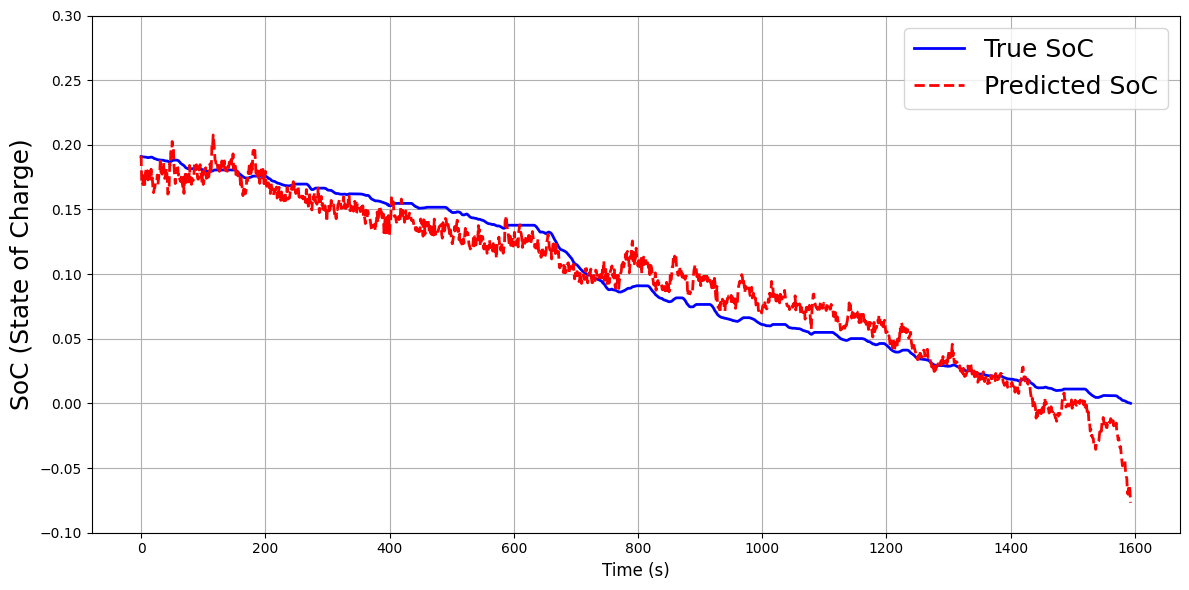

In [25]:
model.eval()
total_val_loss, soc_preds, soc_trues = 0.0, [], []
all_soc_preds, all_soc_trues, all_preds, all_trues = None, None, None, None 

best_val_rmse = 1000
with torch.no_grad():
    if len(val_loader) > 0:
        for xs_scaled, xs_raw, ys in val_loader:
            xs_scaled, xs_raw, ys = xs_scaled.to(device), xs_raw.to(device), ys.to(device)
            pred = model(xs_scaled)
            loss, ul, uoc, soc= loss_fn(pred, xs_raw, ys) 
            total_val_loss += loss.item()
            soc_preds.append(pred[..., 3].detach().cpu())
            soc_trues.append(ys[..., 1].cpu())

        avg_val_loss = total_val_loss / len(val_loader)

        all_preds = torch.cat(soc_preds).view(-1)
        all_trues = torch.cat(soc_trues).view(-1)

        all_soc_preds = all_preds.numpy()
        all_soc_trues = all_trues.numpy()

        soc_rmse = np.sqrt(np.mean((all_soc_preds - all_soc_trues) ** 2))
        soc_mae = np.mean(np.abs(all_soc_preds - all_soc_trues))
    else:
        avg_val_loss, soc_rmse, soc_mae= 0.0, 0.0, 0.0


#print(f"Val Loss: {avg_val_loss:.6f} | UL: {ul:.6f} | UOC: {uoc:.6f} | PDE: {soc:.12f} | SOC RMSE: {soc_rmse:.4f} | SOC MAE: {soc_mae:.4f}")

if all_soc_preds is not None:

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(all_soc_trues, label='True SoC', color='blue', linewidth=2)
    ax.plot(all_soc_preds, label='Predicted SoC', color='red', linestyle='--', linewidth=2)

    #ax.set_title('Test Set: True vs. Predicted SoC', fontsize=18)
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('SoC (State of Charge)', fontsize=18)
    ax.grid(True)
    ax.legend(fontsize=18)
    ax.set_ylim(-0.1, 0.3)

    plt.tight_layout()

    save_path = "../Plots/result_pit_fuds_20c.pdf"
    plt.savefig(save_path)

    plt.show()
